### PyND's Ubiquitin sequencing analysis

Douglas Myers-Turnbull, Paul Thomas, Nick Rettko, and Yuliya Birman.

Goals:
1. Act as an entry point for the data processing pipeline.
2. Load the data into a useful form.
3. Make preliminary sense of the data through simple diagnostics.
4. Determine the statisitical significance of any differences between perturbations and the control.
5. Calculate p-values for mutants from the slopes of the corresponding barcodes.
6. Subtract off the control.
7. Calculate p-values for the differences ("d-values") between perturbations and the control.
8. Plot volcano plots to check the data quality.
9. Make heatmaps and lists of the data with masking based on p-values.
10. Perform basic comparisons between Rosetta stability calculations and fitness scores (the rest is done elsewhere).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import comparison_and_significance as comp
import seq_analysis as seq
import ub_stability as ub

import warnings
from Bio.Seq import Seq
import pandas as pd
import pickle
import numpy as np
import scipy.stats
import utils
import itertools, time
from multiprocessing import Pool, Manager, cpu_count
from timeit import default_timer as timer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotting

/Users/student/anaconda/envs/main/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# How to rerun the analysis from scratch:
# This can run very quickly on a server but will take ~30 min on a Macbook
def calc_barcode_fitness(prefix='', relative=True, hamming_correct=True):
    barcode_fitnesses, codon_fitnesses, aa_fitnesses = seq.process_data("lanes_new_combined.fastq.h5", hamming_correct=hamming_correct)
    barcode_fitnesses.to_hdf(prefix + "barcode_fitness.h5", key="barcode_fitness", mode='w', complevel=9)
    codon_fitnesses.to_hdf(prefix + "fitness.h5", key="codon_fitness", mode='w', complevel=9)
    aa_fitnesses.to_hdf(prefix + "fitness.h5", key="aa_fitness", mode='a', complevel=9)

# How to compute AA and codon fitness from barcode fitnesses:
def calc_fitness(prefix=''):
    barcodes = pd.read_hdf(prefix + "barcode_fitness.h5", key="barcode_fitness")
    codons = seq.calc_fitness_by(barcodes, by_codons=True)
    aas = seq.calc_fitness_by(barcodes)
    codons.to_hdf(prefix + "fitness.h5", key="codon_fitness", mode='w', complevel=9)
    aas.to_hdf(prefix + "fitness.h5", key="aa_fitness", mode='a', complevel=9)


In [ ]:
# This will take a while
# Don't rerun unless necessary

calc_barcode_fitness(hamming_correct=True)

In [ ]:
# Same here

calc_fitness()

In [3]:
# convenience functions for the multiindex dataframe

def load_barcode_fitness():
    return pd.read_hdf("data/barcode_fitness.h5", key="barcode_fitness")

def load_fitness():
    codon_fitness = pd.read_hdf("data/fitness.h5", key="codon_fitness")
    aa_fitness = pd.read_hdf("data/fitness.h5", key="aa_fitness")
    return codon_fitness, aa_fitness

def select(df, index, value):
    return df.iloc[df.index.get_level_values(index) == value]

def unselect(df, index, value):
    return df.iloc[df.index.get_level_values(index) != value]

def load_group_fitness(group = 'PyND'):
    codon_fitness, aa_fitness = load_fitness()
    return select(codon_fitness, 'group', group), select(aa_fitness, 'group', group)

In [4]:
# Just view the barcode dataframe
regular = load_barcode_fitness()
regular.head()

data                                                         fitness  \
                                                           intercept   
group days barcodes           codons amino acids positions             
APC   d1   AAAAAAATCCCGAGTAGA CUA    L           27              NaN   
           AAAAAAATCGCGTACCGA GUU    V           58              NaN   
           AAAAAAGAATAGACAGTT CCU    P           51        -0.574891   
           AAAAAAGATTGATGAGCG ACC    T           27        -1.779290   
           AAAAAAGGATGACAGGCG UGU    C           43        -2.236665   

data                                                                  \
                                                               slope   
group days barcodes           codons amino acids positions             
APC   d1   AAAAAAATCCCGAGTAGA CUA    L           27        -0.996648   
           AAAAAAATCGCGTACCGA GUU    V           58        -0.572471   
           AAAAAAGAATAGACAGTT CCU    P           51        -0.088566   
           AAAAAAGATTGATGAGCG ACC    T           27        -0.111598   
           AAAAAAGGATGACAGGCG UGU    C           43        -0.232825   

data                                                                 counts  \
                                                              stderr     t0   
group days barcodes           codons amino acids positions                    
APC   d1   AAAAAAATCCCGAGTAGA CUA    L           27              NaN     89   
           AAAAAAATCGCGTACCGA GUU    V           58              NaN      1   
           AAAAAAGAATAGACAGTT CCU    P           51         0.073747     72   
           AAAAAAGATTGATGAGCG ACC    T           27         0.045575     34   
           AAAAAAGGATGACAGGCG UGU    C           43         0.219042     28   

data                                                                
                                                            t1  t2  
group days barcodes           codons amino acids positions          
APC   d1   AAAAAAATCCCGAGTAGA CUA    L           27         24 NaN  
           AAAAAAATCGCGTACCGA GUU    V           58        NaN NaN  
           AAAAAAGAATAGACAGTT CCU    P           51         86  51  
           AAAAAAGATTGATGAGCG ACC    T           27         30  23  
           AAAAAAGGATGACAGGCG UGU    C           43         14  14

In [ ]:
# flatten the dataframe and write to CSV for others to use

def flatten(df, level = 0):
    df = df.reset_index()
    df.columns = df.columns.get_level_values(level)
    return df

codon, aa = load_fitness()
codon = flatten(codon)
aa = flatten(aa)
barcode = load_barcode_fitness()
barcode = flatten(barcode)

codon.to_csv('data/codons_weighted.csv')
aa.to_csv('data/aa_weighted.csv')
barcode.to_csv('data/per_barcode_slopes.csv')


In [5]:
# List the group names
by_barcode = pd.read_csv('data/per_barcode_slopes.csv')
by_barcode['group'].unique()

array(['APC', 'Control', 'Et0H', 'Onion', 'PyND', 'Shmoo', 'Whangee'], dtype=object)

In [6]:
# For each group of interest, we're going to load, for each day of interest:
# 1. barcode fitness table
# 2. (AA, position) fitness table
# 3. (codon, position) fitness table.

aa_indices = ['group', 'days', 'positions', 'amino acids']
codon_indices = ['group', 'days', 'positions', 'codons']
barcode_indices = ['group', 'days', 'barcodes', 'codons', 'amino acids', 'positions']

def load_tables(group, csv, indices, day1='d1', day2='d2', slope_name='weighted mean slope', set_columns=None):
    # These vars use names 'aa*' but work for barcode, codon, aa
    by_aa = pd.read_csv(csv)
    by_aa.drop('Unnamed: 0', axis=1, inplace=True) # WTH?
    by_aa.set_index(indices, inplace=True)
    if set_columns is not None:
        by_aa.columns = set_columns
    if slope_name is not None:
        by_aa = by_aa[~by_aa[slope_name].isnull()]
    aa_group = by_aa if group is None else select(by_aa, 'group', group)
    aa_d1 = None
    aa_d2 = None
    if day1 is not None:
        aa_d1 = select(aa_group, 'days', day1)
    if day2 is not None:
        aa_d2 = select(aa_group, 'days', day2)
    return aa_group, aa_d1, aa_d2

def load_aa_tables(group, day1='d1', day2='d2'):
    return load_tables(group, 'data/aa_weighted.csv', aa_indices, day1=day1, day2=day2)

def load_codon_tables(group, day1='d1', day2='d2'):
    return load_tables(group, 'data/codons_weighted.csv', codon_indices, day1=day1, day2=day2)

def load_barcode_tables(group, day1='d1', day2='d2'):
    return load_tables(group, 'data/per_barcode_slopes.csv', barcode_indices, day1=day1, day2=day2, slope_name='slope', set_columns = ['intercept', 'slope', 'stderr', 't0', 't1', 't2'])


# Load the control
aa_ctrl, _, _ = load_aa_tables('Control', day1=None, day2=None)
barcode_ctrl, _, _ = load_barcode_tables('Control', day1=None, day2=None)

# Load the PyND data for day 1 and day 2
aa_pynd, aa_pynd_day1, aa_pynd_day2 = load_aa_tables('PyND')
barcode_pynd, barcode_pynd_day1, barcode_pynd_day2 = load_barcode_tables('PyND')

# Load the Onion data for day 2
# Note that Onion's day 1 data is bad
aa_onion, _, aa_onion_day2 = load_aa_tables('Onion', day1=None)
barcode_onion, _, barcode_onion_day2 = load_barcode_tables('Onion', day1=None)

aa_ctrl.head()

weighted mean slope  sum of t0 reads  \
group   days positions amino acids                                         
Control d1   2         *                      -0.206980               19   
             3         *                      -0.481467               81   
             4         *                      -0.468859               81   
             5         *                      -0.335738              115   
             6         *                      -0.520222              150   

                                    # unique barcodes  stddev of slope  \
group   days positions amino acids                                       
Control d1   2         *                            2         0.176244   
             3         *                            7         0.136762   
             4         *                           14         0.527079   
             5         *                           10         0.117357   
             6         *                           10         0.296720   

                                    unweighted mean slope  weighted stddev  
group   days positions amino acids                                          
Control d1   2         *                        -0.247211         0.022409  
             3         *                        -0.467151         0.034631  
             4         *                        -0.506124         0.030874  
             5         *                        -0.265913         0.028856  
             6         *                        -0.598237         0.029606

In [ ]:
# Make a heatmap of position, aa, fitness for control

sns.set(rc={"figure.figsize": (120, 60)}, font_scale=5)
plotting.plot_masked_mutant_wt_heatmap(aa_ctrl, filter_fn=None)

In [ ]:
# Repeat for day 1
sns.set(rc={"figure.figsize": (120, 60)}, font_scale=5)
plotting.plot_masked_mutant_wt_heatmap(aa_pynd_day1, filter_fn=None)

In [ ]:
# Now for day 2
sns.set(rc={"figure.figsize": (120, 60)}, font_scale=5)
plotting.plot_masked_mutant_wt_heatmap(aa_pynd_day2, filter_fn=None)

In [ ]:
# How many mutations do we have for each AA in the control?
aa_control_counts = pd.DataFrame({'count' : aa_ctrl.groupby(level = ['amino acids']).size()}).reset_index().set_index(['amino acids'])
aa_control_counts.index.name = 'AA'
aa_control_counts.columns = ['count']
aa_control_counts

In [7]:
# Let's make data frames for all of the samples combined

aa_combined = aa_ctrl.copy()
aa_combined = aa_combined.append(aa_ctrl)
aa_combined = aa_combined.append(aa_pynd_day1)
aa_combined = aa_combined.append(aa_pynd_day2)

barcode_combined = barcode_ctrl.copy()
barcode_combined = barcode_combined.append(barcode_ctrl)
barcode_combined = barcode_combined.append(barcode_pynd_day1)
barcode_combined = barcode_combined.append(barcode_pynd_day2)

# Sanity check that they look right
print(barcode_combined.index.levels[0].unique())
print(barcode_combined.index.levels[1].unique())

print(aa_combined.index.levels[0].unique())
print(aa_combined.index.levels[1].unique())

['Control' 'PyND']
['d1' 'd2']
['Control' 'PyND']
['d1' 'd2']


In [8]:
# What are the average fitness scores for each sample?

doses = {'d1': 1.25, 'd2': 0.625, 'control': 0.0}
doses_nice = {'d1': '1.250 ug/ml', 'd2': '0.625  ug/ml', 'control': 'control'}

mean_diffs = pd.DataFrame([{'sample': doses_nice['d1'], 'fitness': aa_pynd_day1['weighted mean slope'].mean()}, {'sample': doses_nice['d2'], 'fitness': aa_pynd_day2['weighted mean slope'].mean()}, {'sample': 'control', 'fitness': aa_ctrl['weighted mean slope'].mean()}])
mean_diffs.set_index('sample', inplace=True)
mean_diffs

,fitness
sample,
1.250 ug/ml,-0.175108
0.625 ug/ml,-0.070435
control,-0.133371


In [ ]:
# What do the distributions of mutation fitnesses look like?

sns.set(rc={"figure.figsize": (30, 20)}, font_scale=3)
sns.set_style("whitegrid")

sns.distplot(aa_ctrl['weighted mean slope'], label='control', norm_hist=True, kde=False, hist=True)
sns.distplot(aa_pynd_day2['weighted mean slope'], label=doses_nice['d2'], norm_hist=True, kde=False, hist=True)
sns.distplot(aa_pynd_day1['weighted mean slope'], label=doses_nice['d1'], norm_hist=True, kde=False, hist=True)


In [ ]:
# Statistical significance of differences between cases and control

#print("Anderson-Darling %s" % ())
ad = scipy.stats.anderson_ksamp([aa_pynd_day1['weighted mean slope'], aa_pynd_day2['weighted mean slope'], aa_ctrl['weighted mean slope']])
# TODO what's wrong with the AD test?
# Don't use for now
print("Anderson-Darling: stat=%d; p=%.3E" % (ad[0], ad[-1]))

from collections import OrderedDict
sample_values_dict = OrderedDict()
sample_values_dict['control'] = aa_ctrl['weighted mean slope']
sample_values_dict['d2'] = aa_pynd_day2['weighted mean slope']
sample_values_dict['d1'] = aa_pynd_day1['weighted mean slope']
comp.pairwise_ks_tests(sample_values_dict, doses_nice)


In [ ]:
# There are various scatter plots we want, mostly as diagnostics

def plot_scatter(df, x, y, xlim=[0,], ylim=[0, ], size=20, fitreg=False, jointplot=False, hue=None):
    if jointplot:
        sns.jointplot(aa_ctrl[x], aa_ctrl[y], kind="kde", size=7, space=0)
        sns.jointplot(aa_ctrl[x], aa_ctrl[y], kind="kde", size=7, space=0)
    else:
        lm = sns.lmplot(data=df, x=x, y=y, size=size, fit_reg=fitreg, scatter_kws={"s": 50}, hue=hue)
        axes = lm.axes
        if xlim is not None:
            axes[0,0].set_xlim(*xlim)
        if ylim is not None:
            axes[0,0].set_ylim(*ylim)
    


In [ ]:
# plot counts vs stddev for all groups

def plot_std_vs_log_mean(df):
    sns.set_style("white")
    sns.set(rc={"figure.figsize": (30, 20)}, font_scale=3)
    ax = sns.jointplot("log10(sum of t0 reads)", "stddev of slope", data=df[~pd.isnull(df["stddev of slope"])], kind="kde", ylim=(0, 0.6), xlim=(0, 6), size=20)
    plt.subplots_adjust(top=0.85)
    return plt.gcf()


sns.set_style("white")
aa_total, _, _ = load_aa_tables(None, day1=None, day2=None)
aa_total['log10(sum of t0 reads)'] = np.log10(aa_total['sum of t0 reads'])
using = aa_total.dropna().copy()
using['binned t0'] = pd.cut(using['log10(sum of t0 reads)'], bins=100)
using

In [ ]:
# Plot lots of diagnostic scatter plots

def add_log10_t0(df):
    df['log10(sum of t0 reads)'] = df['sum of t0 reads'].map(lambda r: np.log10(r))

def plot_scatters(df, size=20):
    add_log10_t0(df)
    plot_scatter(df, 'log10(sum of t0 reads)', 'weighted stddev', size=size)
    plot_scatter(df, 'log10(sum of t0 reads)', 'stddev of slope', size=size)
    plot_scatter(df, 'weighted mean slope', 'weighted stddev', size=size, xlim=None)
    plot_scatter(df, 'weighted mean slope', 'stddev of slope', size=size, xlim=None)
    plot_scatter(df, 'unweighted mean slope', 'weighted stddev', size=size, xlim=None)
    plot_scatter(df, 'unweighted mean slope', 'stddev of slope', size=size, xlim=None)
    
# TODO: what's with the warnings?
plot_scatters(aa_onion_day2, size=20)
plot_scatters(aa_ctrl, size=20)

### Mutant vs. WT p-values and volcano plots


In [9]:

def calc_pvals_and_plot_volcano(by_barcode, by_mutant, xlim=None, ylim=None, hue=None, by_codon=False, weighted=True):
    x = comp.calc_wt_mutant_pvals(by_barcode, by_mutant, weighted=weighted, method=comp.welch_test)
    sns.set(rc={"figure.figsize": (60, 40)}, font_scale=3)
    plotting.plot_mutant_wt_volcano(x, slope_column='weighted mean slope' if weighted else 'unweighted mean slope', xlim=xlim, ylim=ylim, hue=hue)
    return x


In [ ]:
_ = calc_pvals_and_plot_volcano(barcode_ctrl, aa_ctrl, weighted=False)

/Users/student/anaconda/envs/main/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/student/Desktop/SCRUB/seq-analysis/comparison_and_significance.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  barcode_df[pval_col_name] = barcode_df.apply(lambda x: _test_wt_mutant(df, x, plain_wt, weighted_wt, mutant_type, weighted=weighted, method=method), axis=1)
/Users/student/Desktop/SCRUB/seq-analysis/comparison_and_significance.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

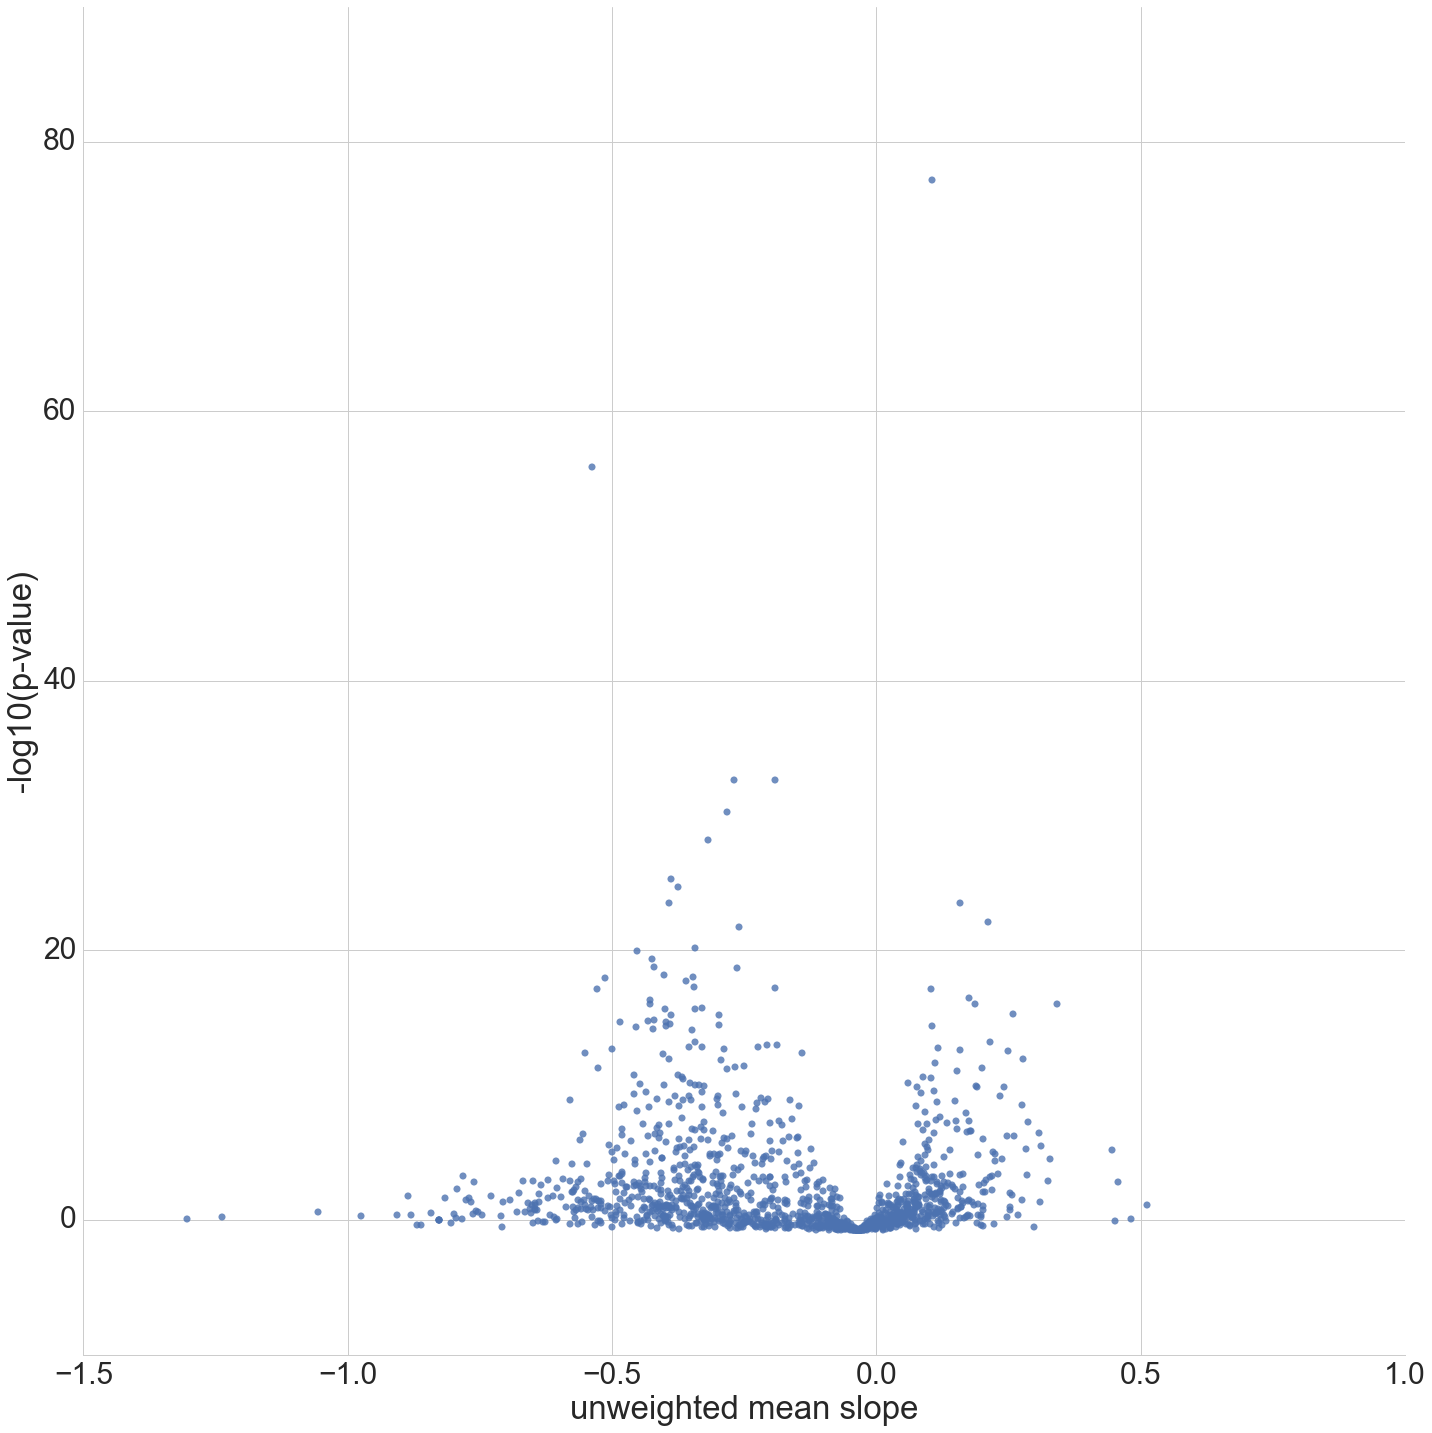

In [11]:
_ = calc_pvals_and_plot_volcano(barcode_pynd_day1, aa_pynd_day1, weighted=False)

In [ ]:
# TODO: Volcano plots for combined data, color-coded


/Users/student/anaconda/envs/main/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/student/anaconda/envs/main/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/student/anaconda/envs/main/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


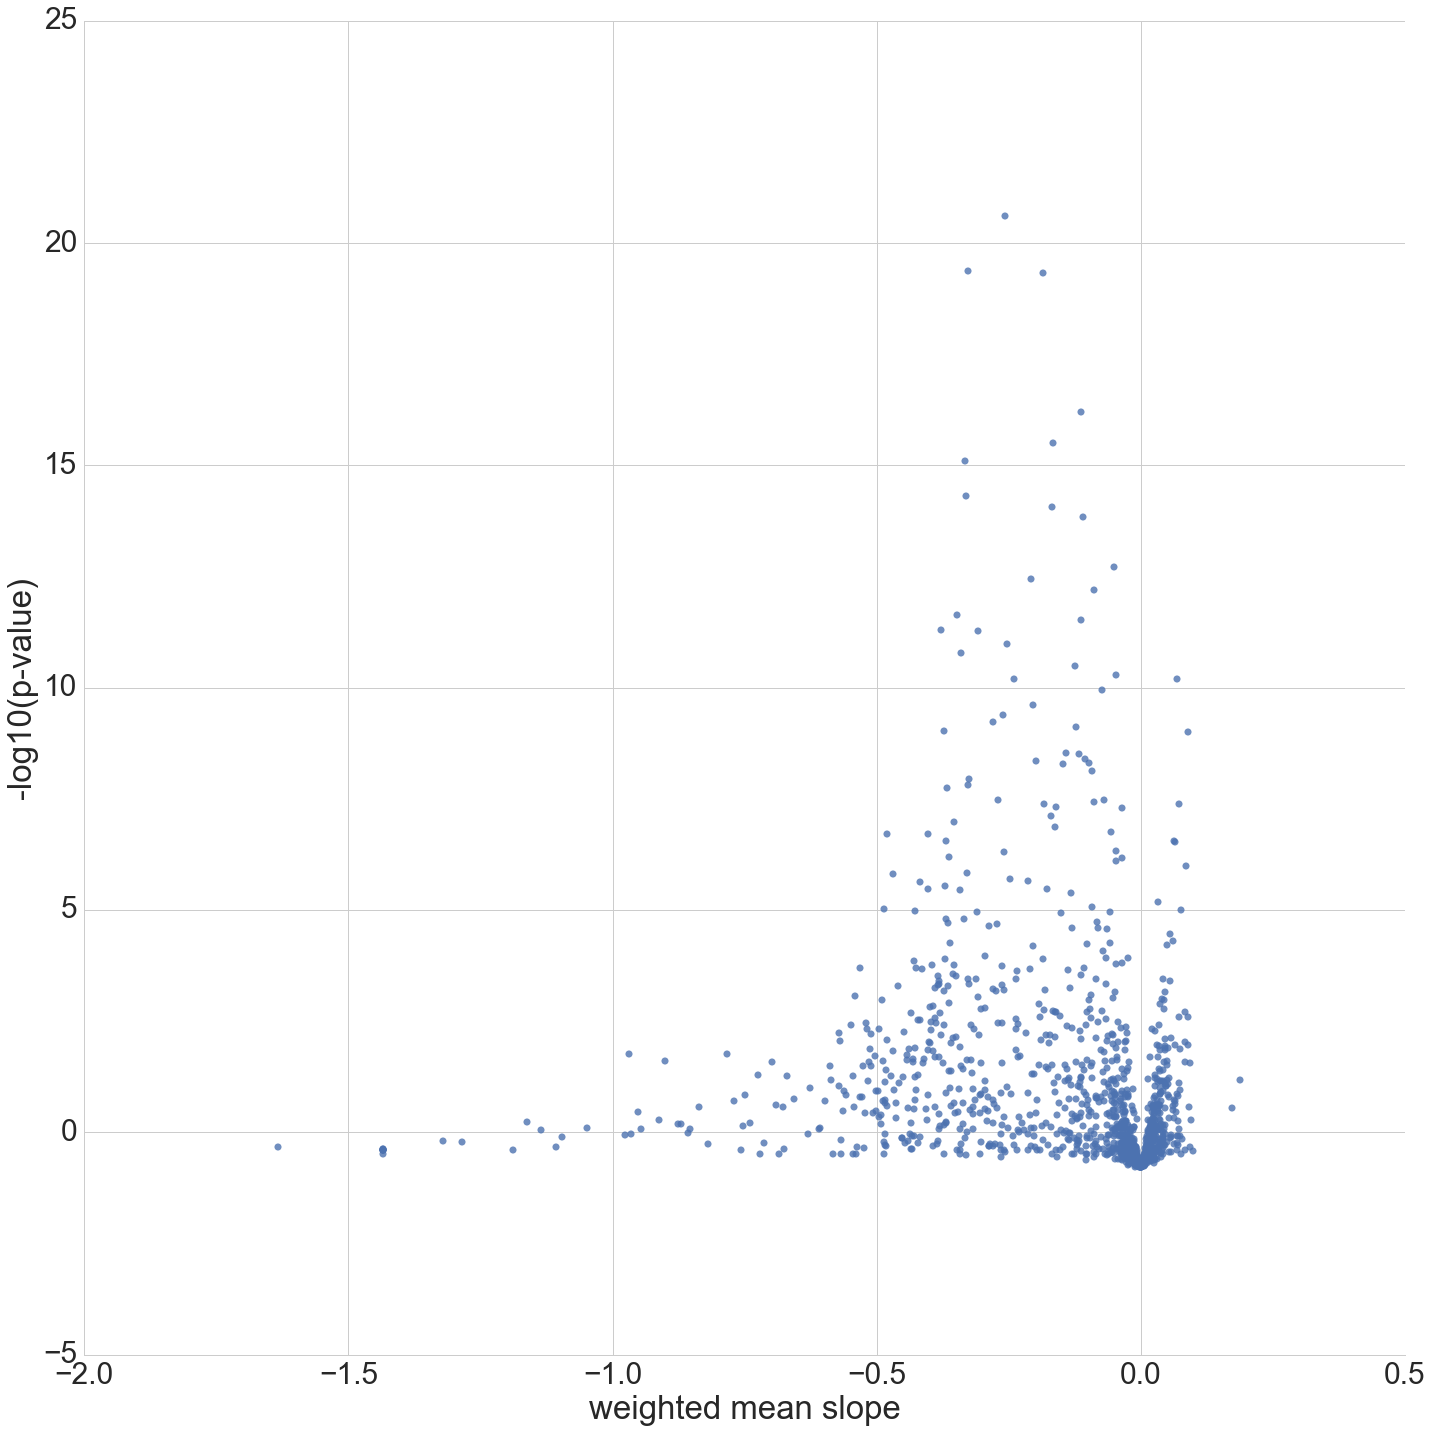

In [12]:
# Volcano plots for control
aa_ctrl = calc_pvals_and_plot_volcano(barcode_ctrl, aa_ctrl)


/Users/student/anaconda/envs/main/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/student/Desktop/SCRUB/seq-analysis/comparison_and_significance.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  barcode_df[pval_col_name] = barcode_df.apply(lambda x: _test_wt_mutant(df, x, plain_wt, weighted_wt, mutant_type, weighted=weighted, method=method), axis=1)
/Users/student/Desktop/SCRUB/seq-analysis/comparison_and_significance.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

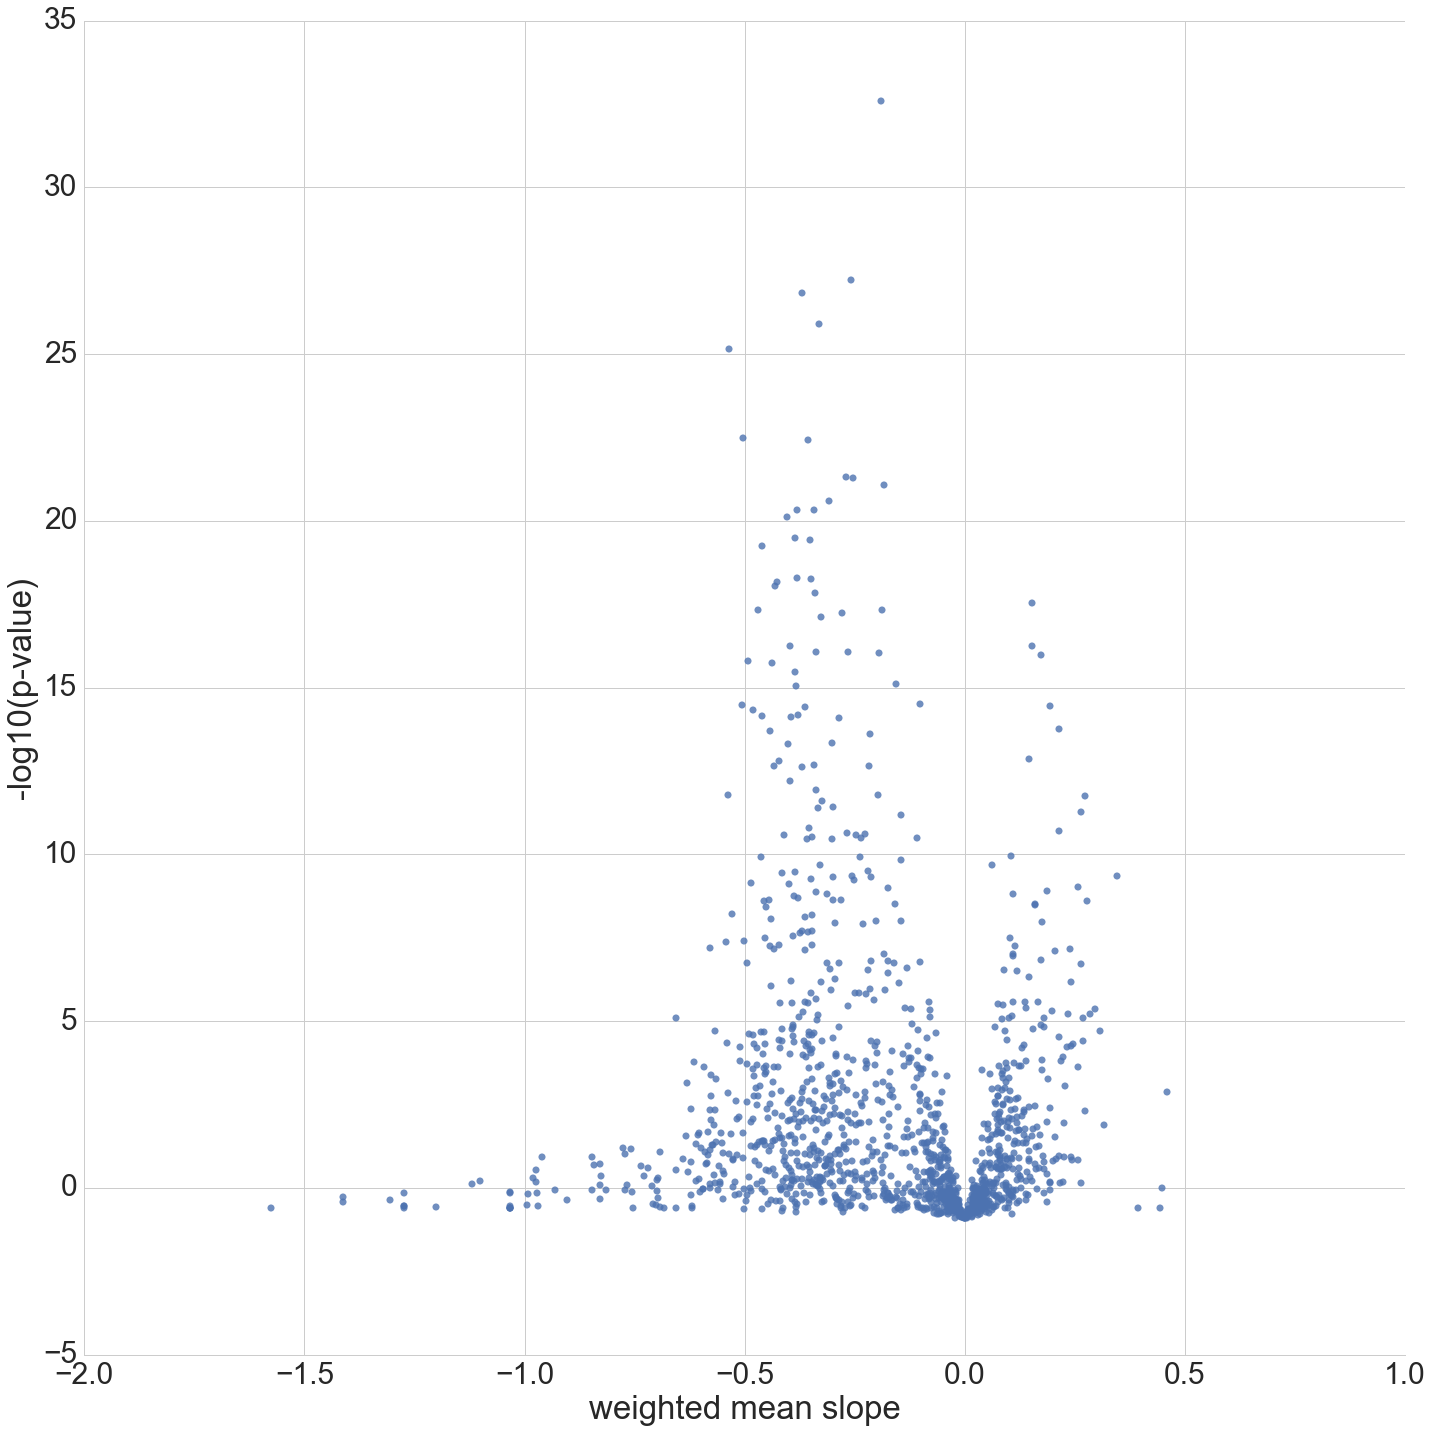

In [13]:
# Volcano plots for Pynd day 1
aa_pynd_day1 = calc_pvals_and_plot_volcano(barcode_pynd_day1, aa_pynd_day1)


In [ ]:
# Volcano plots for Pynd day 2
aa_pynd_day2 = calc_pvals_and_plot_volcano(barcode_pynd_day2, aa_pynd_day2)


In [ ]:
# Volcano plots for Onion
barcode_onion_day2 = calc_pvals_and_plot_volcano(barcode_onion_day2, aa_onion_day2, weighted=False)

# TODO: What's causing the warning about slicing?
# We can ignore the warning from matplotlib; it's not our fault and isn't a problem


### Perturbation vs. control differences, d-values, and volcano plots

In [14]:
# Calculate diffs for day 1
diff_day1 = comp.calc_case_control_diff(aa_pynd_day1, aa_ctrl)
diff_day1 = comp.calc_case_control_pvals(diff_day1, barcode_ctrl, barcode_pynd_day1, method=comp.welch_test)
diff_day1.to_csv('output/day1_ctrl_diffs.csv')
diff_day1.sort_values('case-control slope diff').head()

# TODO: What's with the d.o.f warning from Numpy?

/Users/student/anaconda/envs/main/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


FileNotFoundError: [Errno 2] No such file or directory: 'output/day1_ctrl_diffs.csv'

In [ ]:
# Calculate diffs for day 2
diff_day2 = comp.calc_case_control_diff(aa_pynd_day2, aa_ctrl)
diff_day2 = comp.calc_case_control_pvals(diff_day2, barcode_ctrl, barcode_pynd_day2, method=comp.welch_test)
diff_day2.to_csv('output/day2_ctrl_diffs.csv')
diff_day2.sort_values('case-control slope diff').head()

In [ ]:

barcode_onion, _, barcode_onion_day2 = load_barcode_tables('Onion', day1=None)

barcode_onion_day2.head()


In [ ]:
# Calculate diffs for Onion day 2
diff_onion_day2 = comp.calc_case_control_diff(aa_onion_day2, aa_ctrl, weighted=False)
diff_onion_day2 = comp.calc_case_control_pvals(diff_onion_day2, barcode_ctrl, barcode_onion_day2, weighted=False, method=comp.welch_test)
diff_onion_day2.to_csv('output/day2_onion_diffs.csv')
diff_onion_day2.sort_values('case-control slope diff').head()

/Users/student/anaconda/envs/main/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


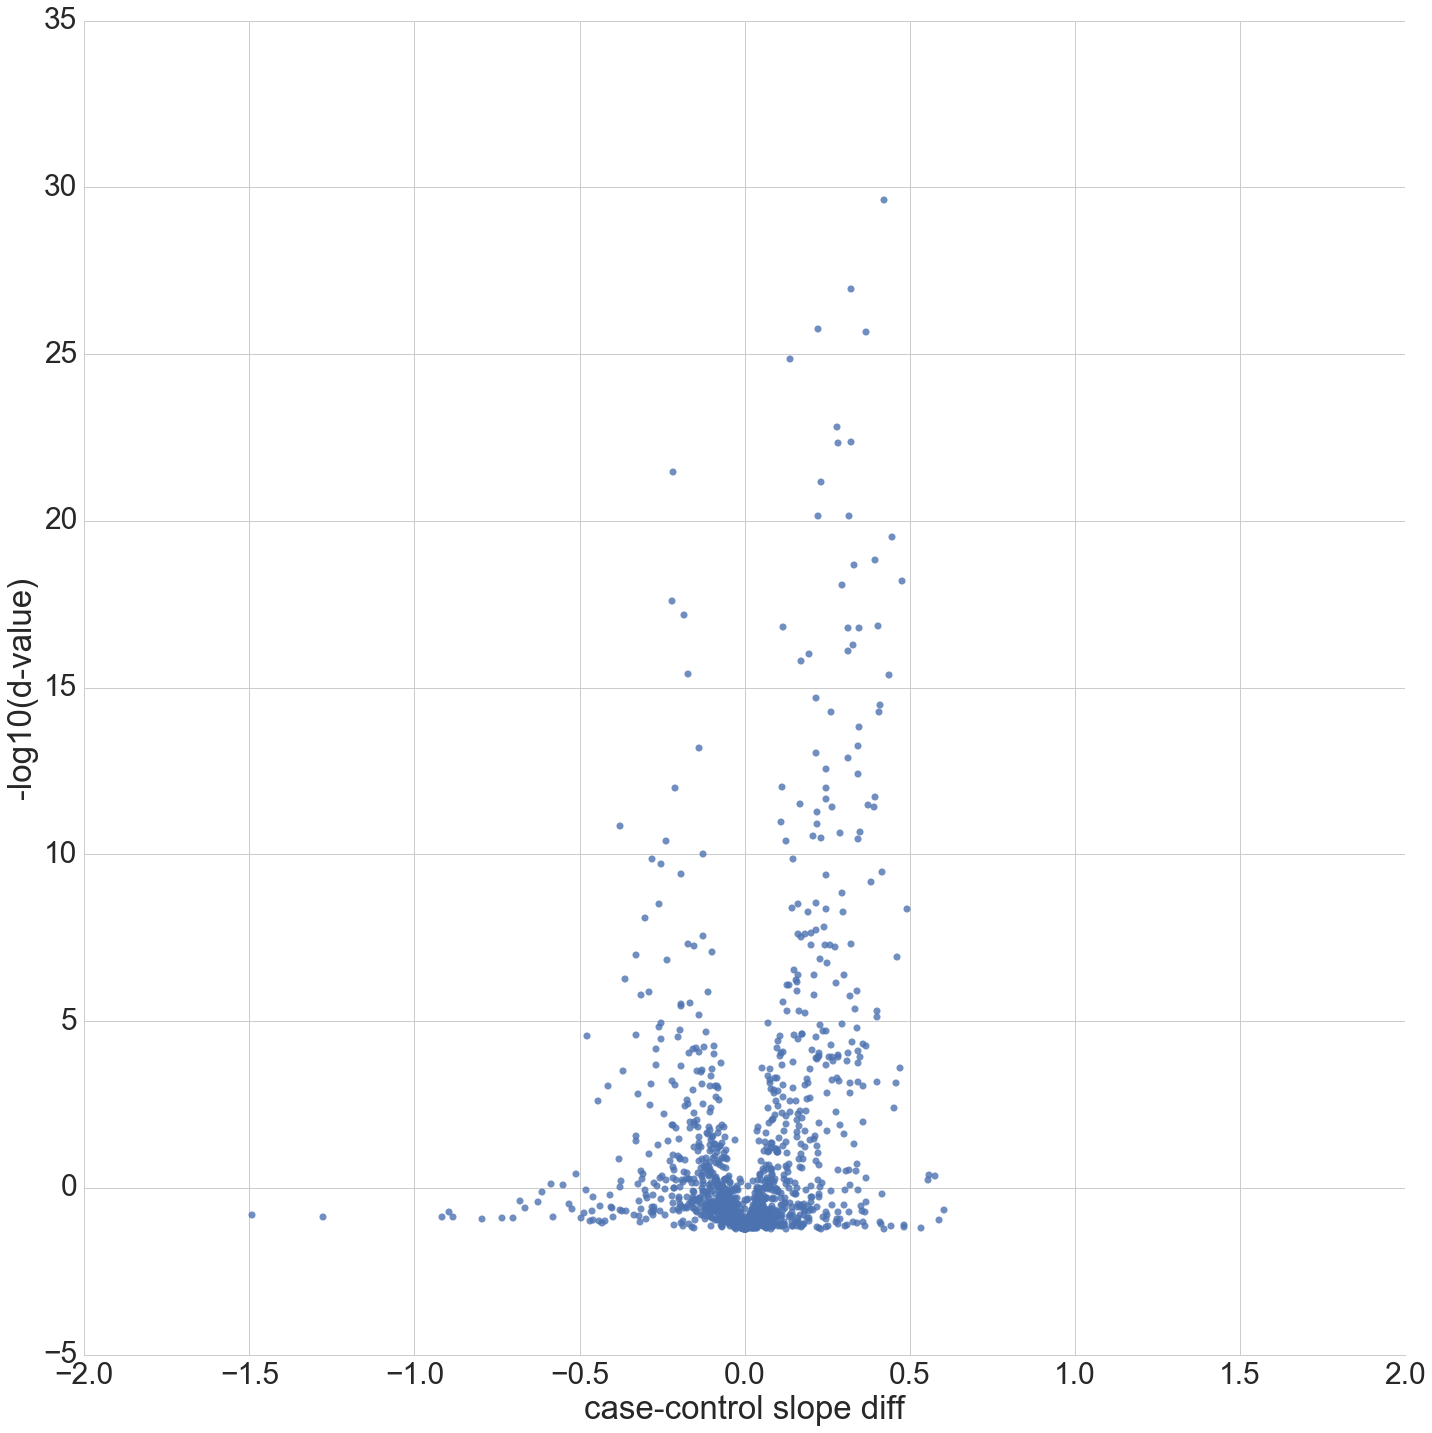

In [15]:
# Plot volcanos for PyND

plotting.plot_case_control_volcano(diff_day1) # defaults to p-value < 0.05 filter
plotting.plot_case_control_volcano(diff_day2)


In [ ]:
# Plot volcanos for Onion

plotting.plot_case_control_volcano(diff_onion_day2, xlim=(-1.0, 1.0), ylim=(-2, 20))



### Plot heatmaps and write files for p- and d-value filtered data

In [16]:
# Plot case vs. control with p-value filters for case and control and a d-value filter

def check(row):
    return row['p-value'] > cutoff

def diff_check(row):
    return (row['p-value: case'] > cutoff and row['p-value: control'] > cutoff) or row['d-value'] > cutoff
    

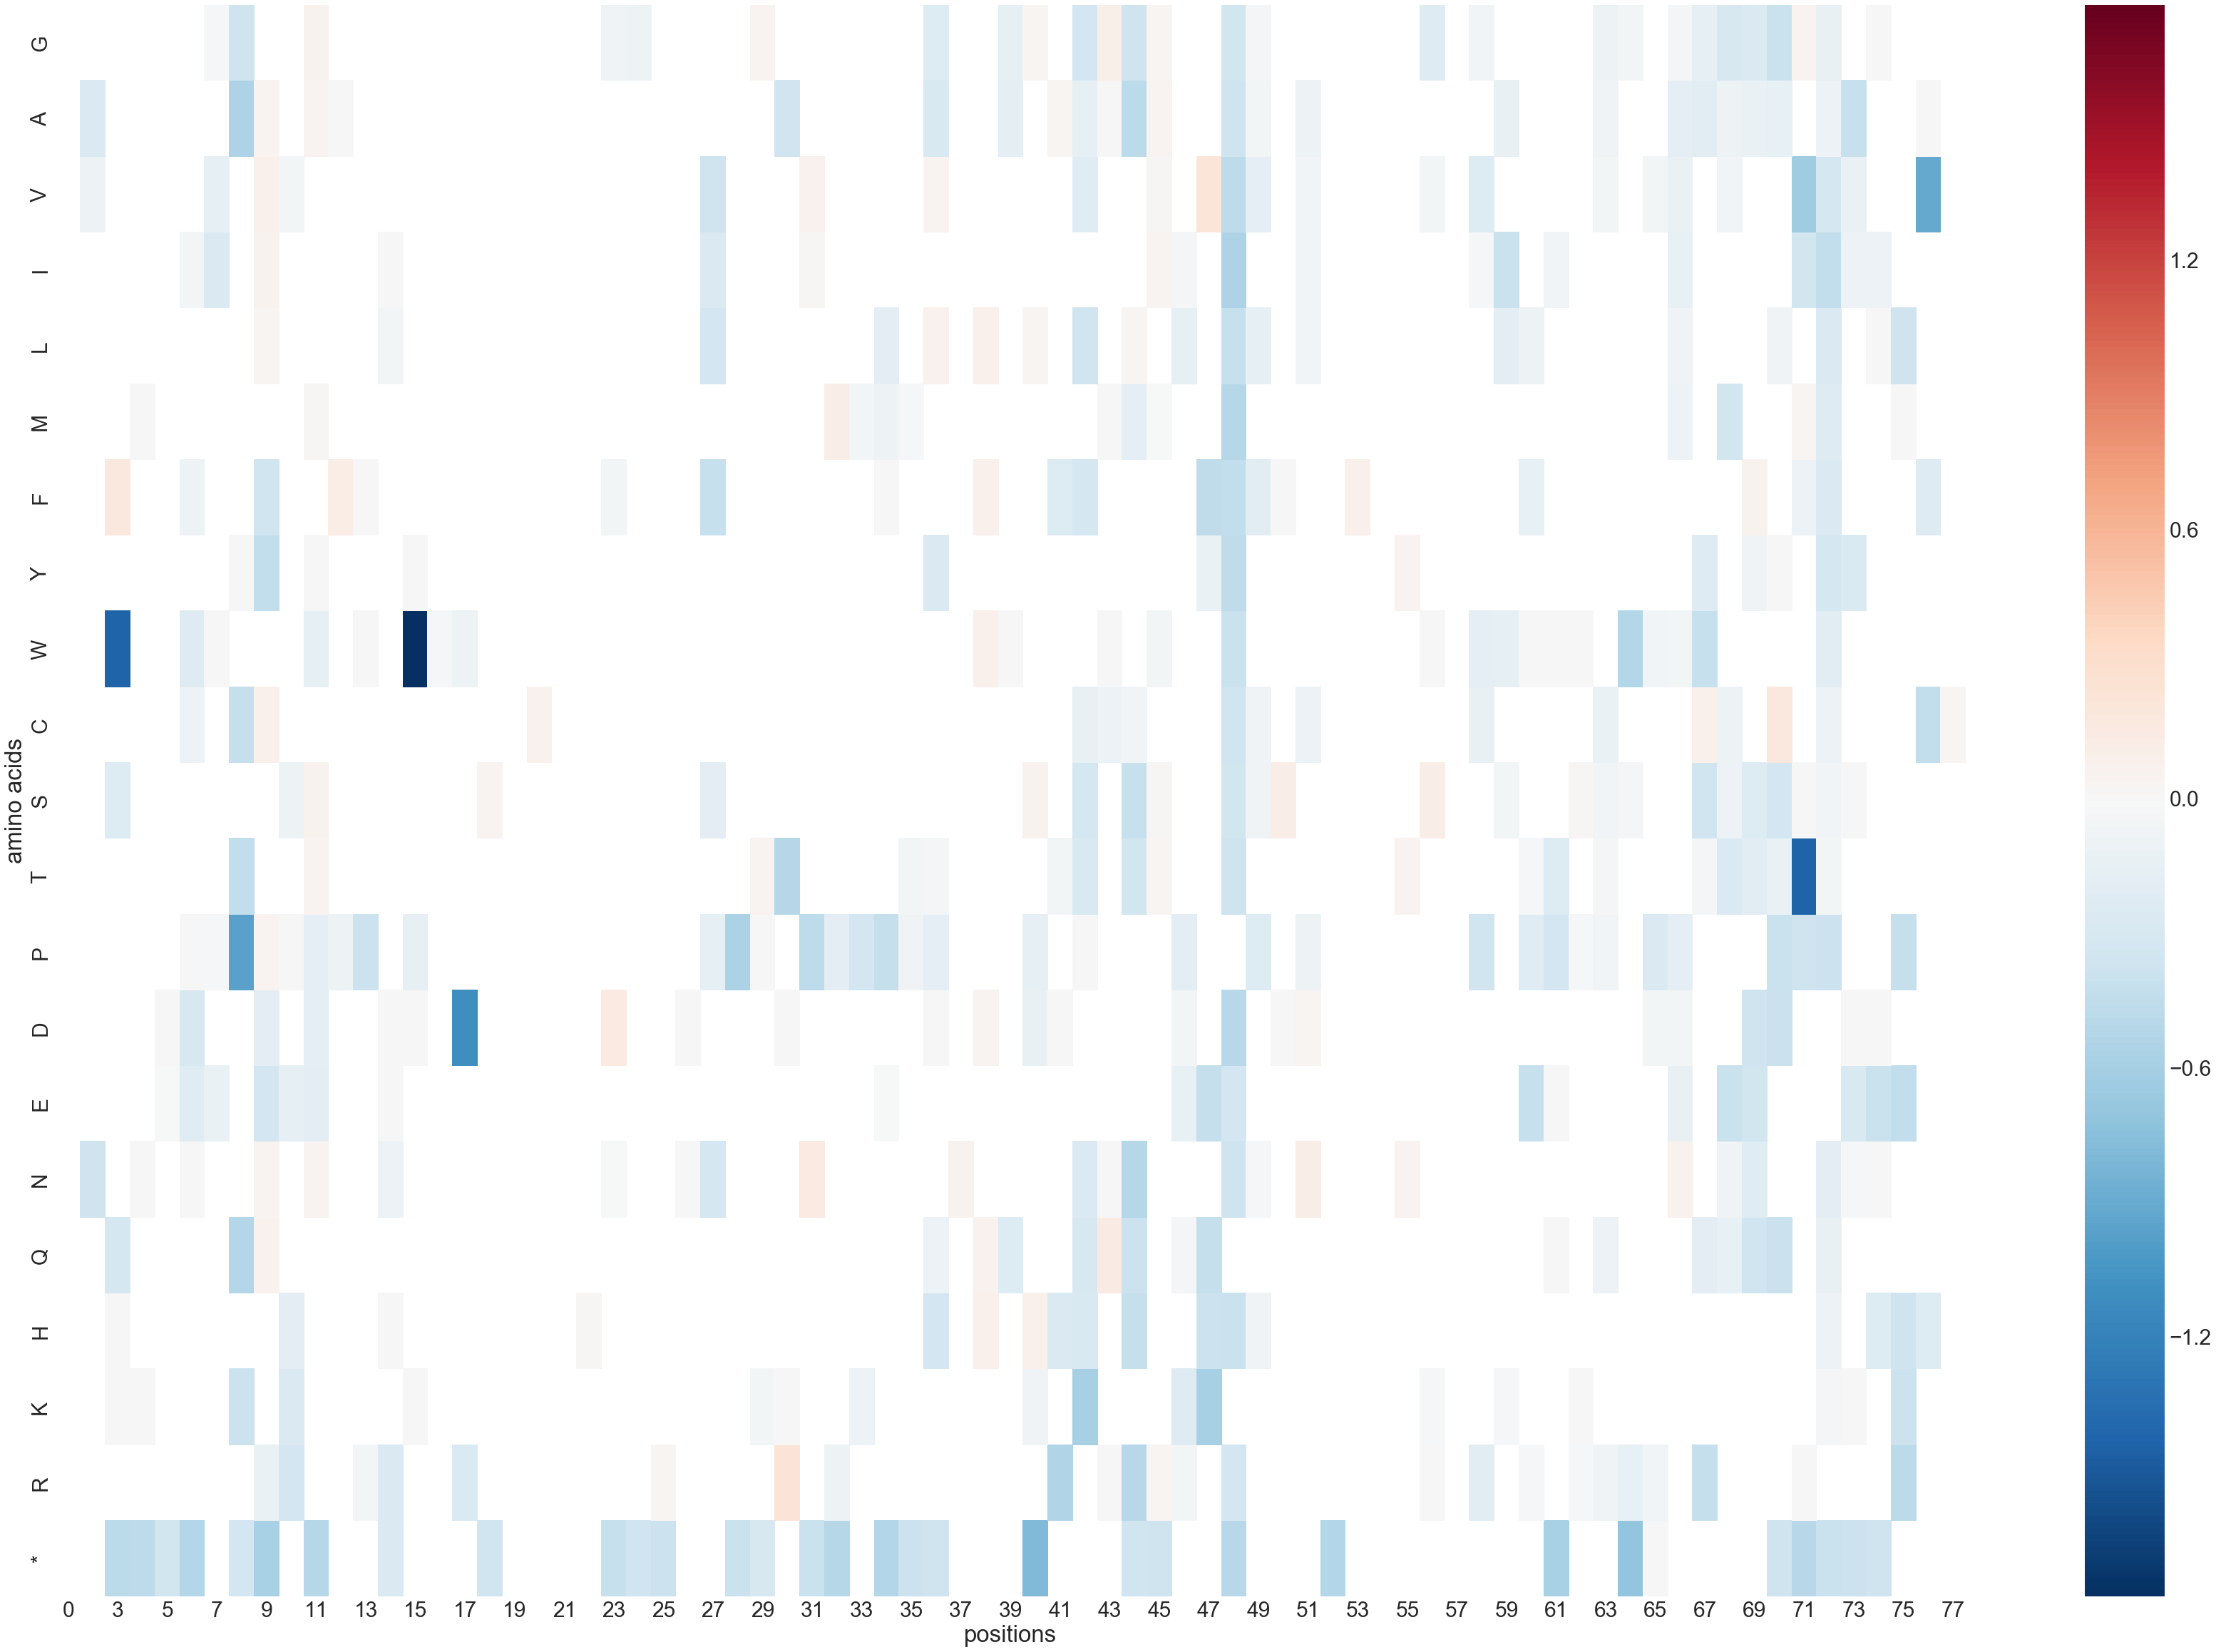

In [17]:

plotting.plot_masked_mutant_wt_heatmap(aa_ctrl) # defaults to (p-value(1) < 0.05 or p-value(2) < 0.05) and d-value < 0.05


In [ ]:

plotting.plot_masked_mutant_wt_heatmap(aa_pynd_day1)


In [ ]:

plotting.plot_masked_mutant_wt_heatmap(aa_pynd_day2)


/Users/student/anaconda/envs/main/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


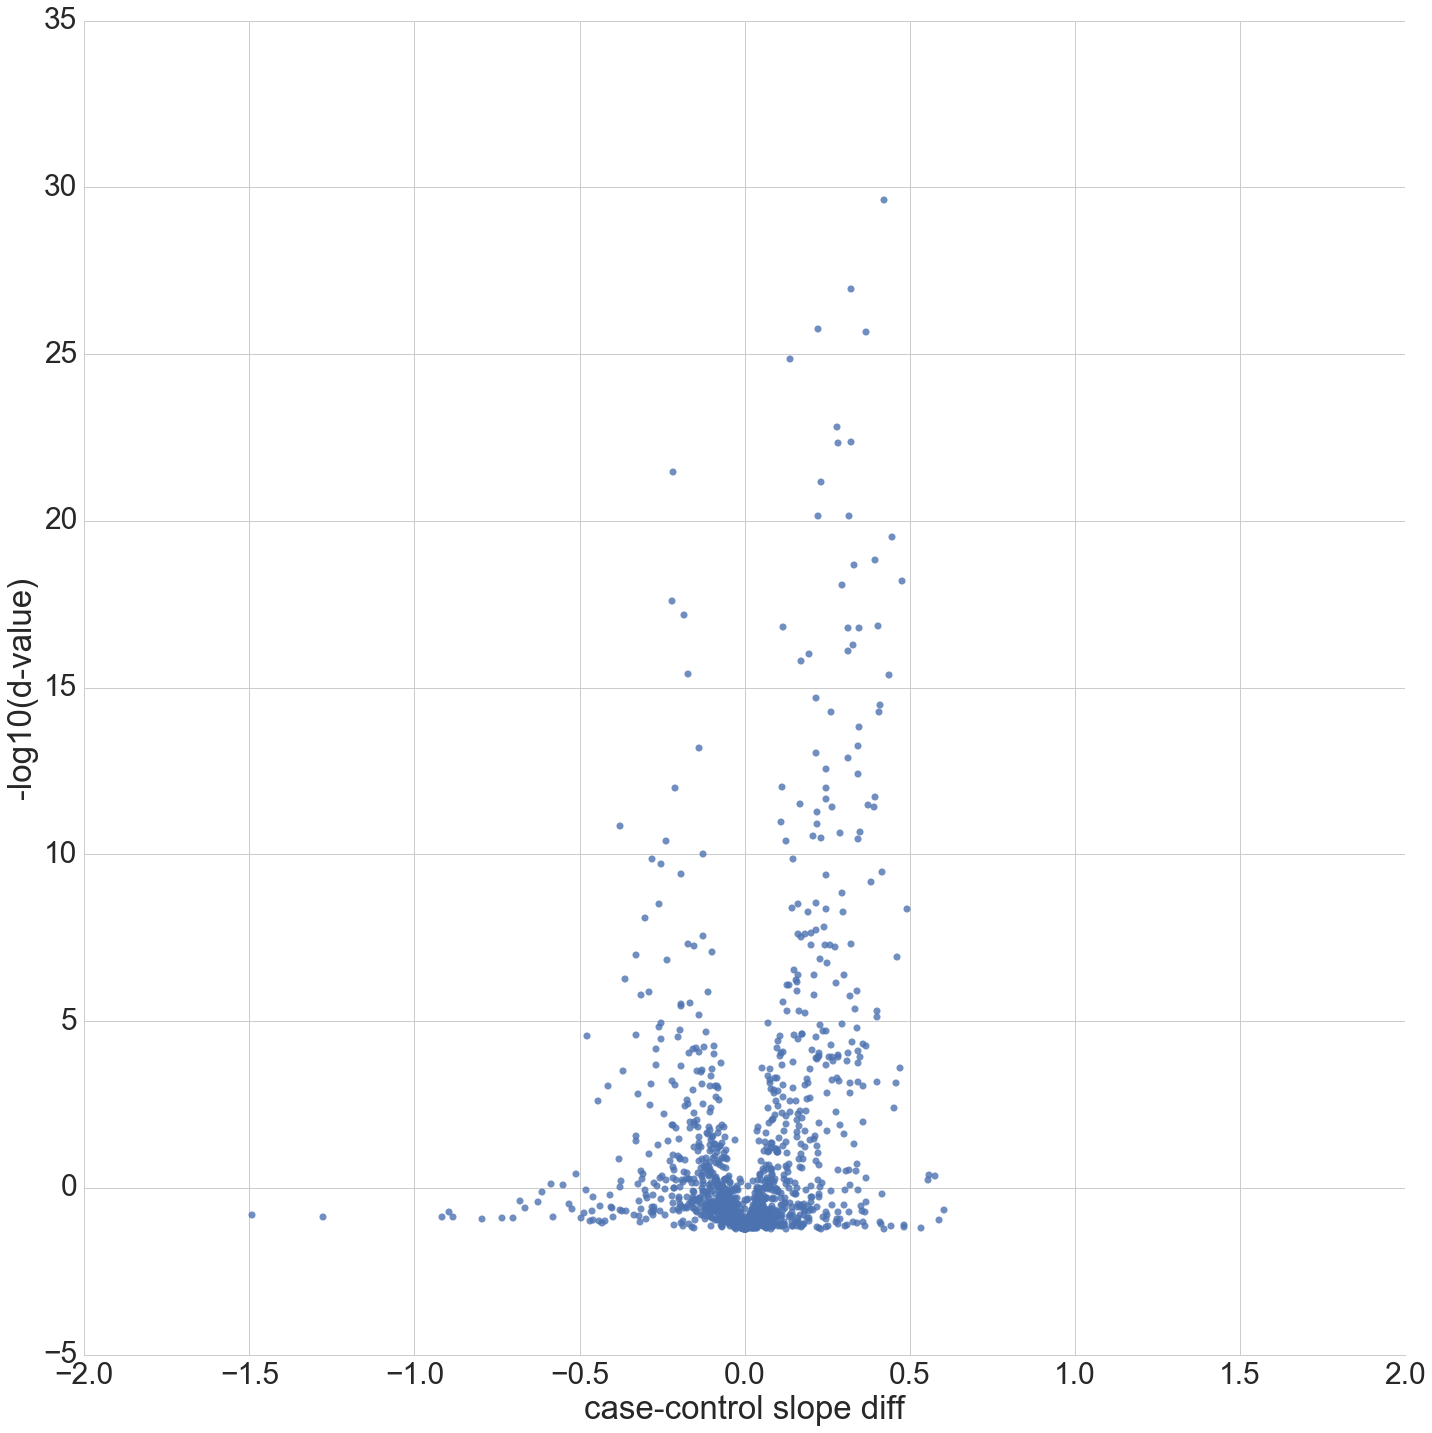

In [18]:

plotting.plot_case_control_volcano(diff_day1)


In [ ]:

plotting.plot_case_control_volcano(diff_day2)


In [ ]:

plotting.plot_case_control_volcano(diff_onion_day2)


In [ ]:
sig_diff_day1 = diff_day1[diff_day1.apply(diff_check, axis=1)]
sig_diff_day2 = diff_day2[diff_day2.apply(diff_check, axis=1)]

mean_diff_day1_ctrl = sig_diff_day1.groupby(level = ['positions'])['slope_diff'].mean()
mean_diff_day2_ctrl = sig_diff_day2.groupby(level = ['positions'])['slope_diff'].mean()
mean_diff_day1_ctrl.to_csv('output/mean_diff_by_position_day1vsctrl_maxpval0.05_dval0.05.csv')
mean_diff_day2_ctrl.to_csv('output/mean_diff_by_position_day2vsctrl_maxpval0.05_dval0.05.csv')


In [19]:
# What's stat. significance of the difference between the day 1 case and control?

scipy.stats.pearsonr(x = diff_day1['weighted mean slope: control'], y = diff_day1['weighted mean slope: case'])

(0.53302395315301743, 2.0841659725174467e-105)

### Load and analyze Rosetta stability calculations

In [96]:
# Load Ubiquitin Rosetta statibility calculations
stability = ub.load_stability_data(mutation_df=diff_day1)
stability

# unique barcodes: case  # unique barcodes: control  \
positions amino acids                                                        
0         WT                               604                         632   
1         A                                NaN                         NaN   
          A                                NaN                         NaN   
          A                                NaN                         NaN   
          A                                NaN                         NaN   
          A                                NaN                         NaN   
          A                                NaN                         NaN   
          A                                NaN                         NaN   
          A                                NaN                         NaN   
          A                                NaN                         NaN   
          A                                NaN                         NaN   
          C                                NaN                         NaN   
          C                                NaN                         NaN   
          C                                NaN                         NaN   
          C                                NaN                         NaN   
          C                                NaN                         NaN   
          C                                NaN                         NaN   
          C                                NaN                         NaN   
          C                                NaN                         NaN   
          C                                NaN                         NaN   
          C                                NaN                         NaN   
          D                                NaN                         NaN   
          D                                NaN                         NaN   
          D                                NaN                         NaN   
          D                                NaN                         NaN   
          D                                NaN                         NaN   
          D                                NaN                         NaN   
          D                                NaN                         NaN   
          D                                NaN                         NaN   
          D                                NaN                         NaN   
...                                        ...                         ...   
76        R                                  6                          11   
          R                                  6                          11   
          R                                  6                          11   
          S                                  8                          17   
          S                                  8                          17   
          S                                  8                          17   
          S                                  8                          17   
          S                                  8                          17   
          T                                  8                          14   
          T                                  8                          14   
          T                                  8                          14   
          T                                  8                          14   
          T                                  8                          14   
          V                                  6                           8   
          V                                  6                           8   
          V                                  6                           8   
          V                                  6                           8   
          V                                  6                           8   
          W                                  

/Users/student/anaconda/envs/main/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


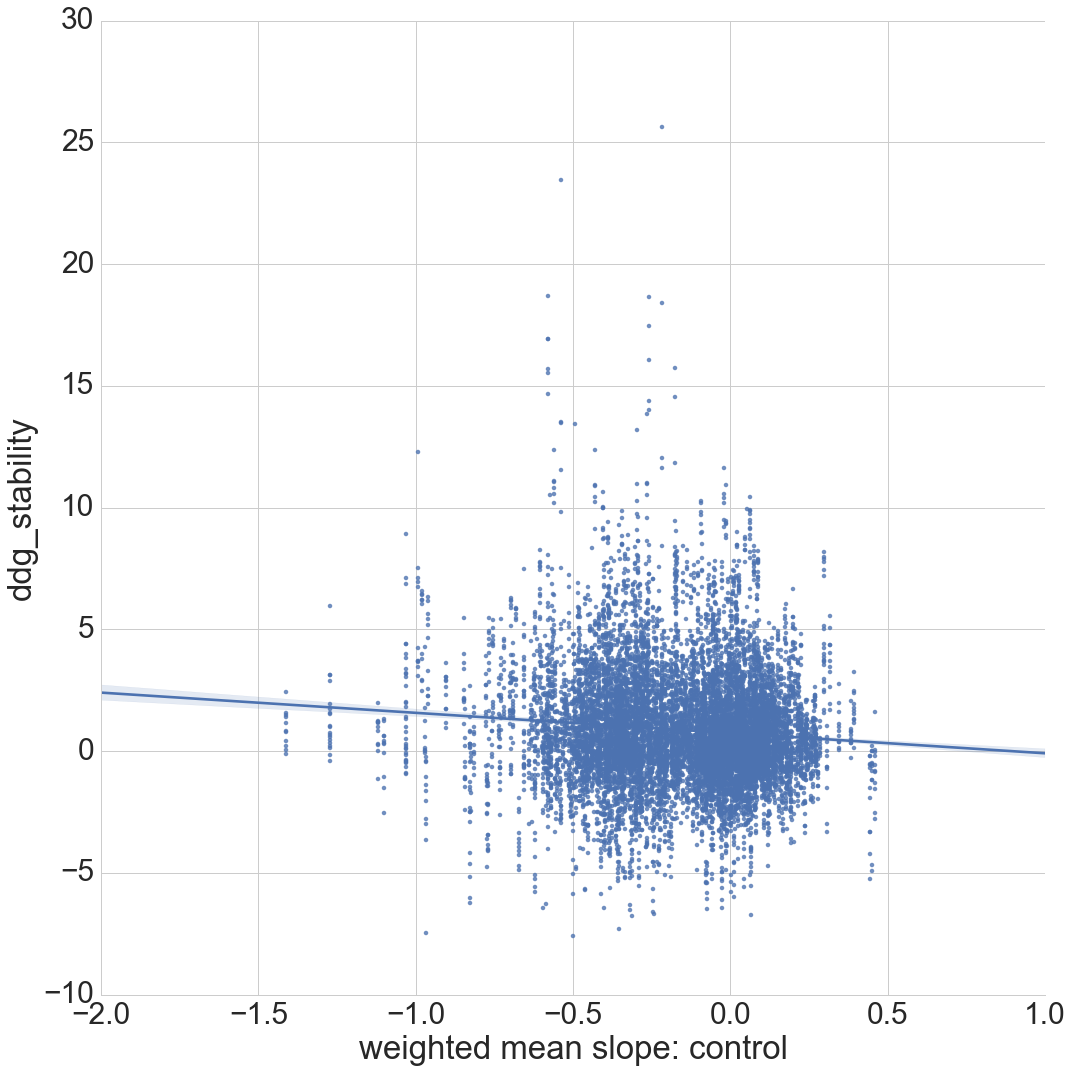

In [100]:
sns.lmplot(x='weighted mean slope: control', y='ddg_stability', data=stability, size=15)

/Users/student/anaconda/envs/main/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


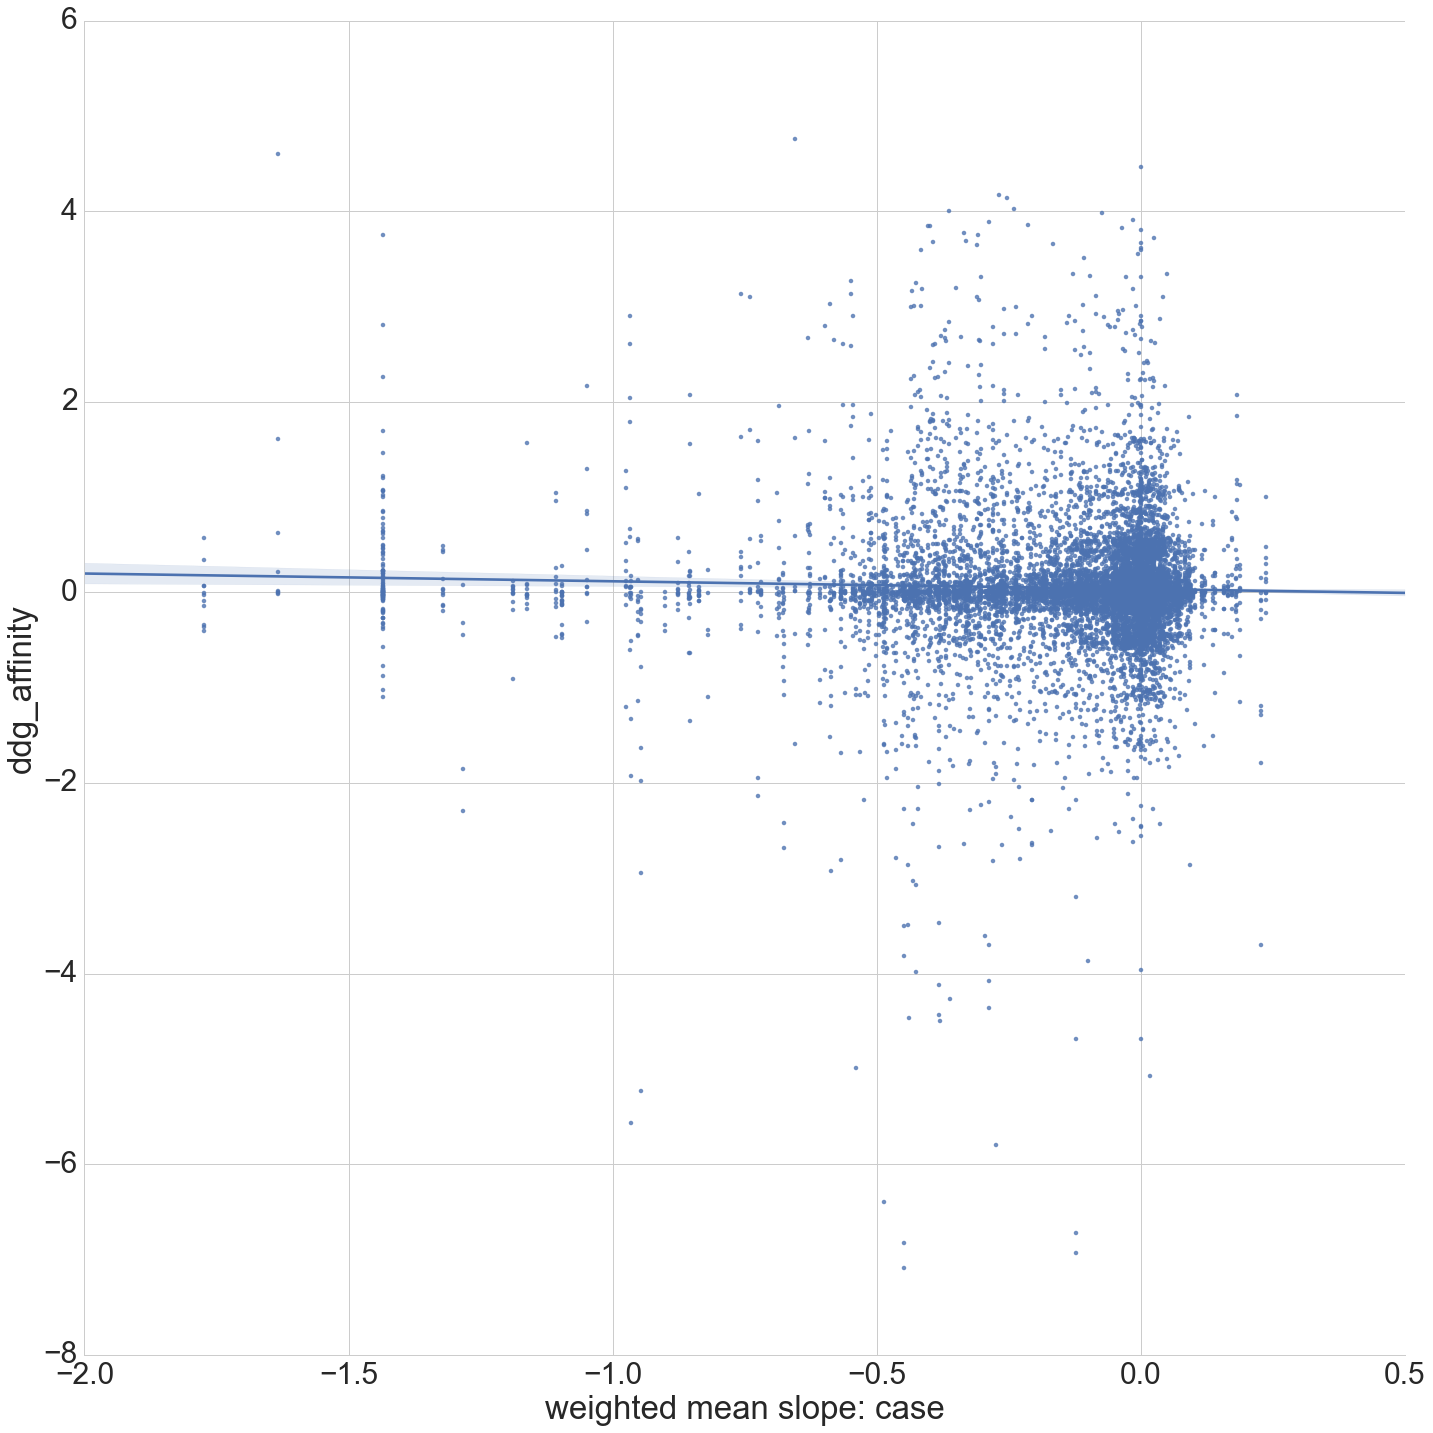

In [99]:
sns.lmplot(x='weighted mean slope: control', y='ddg_affinity', data=stability, size=15)

In [101]:
scipy.stats.spearmanr(stability['weighted mean slope: control'], stability['ddg_stability'])

SpearmanrResult(correlation=-0.07942388510547406, pvalue=2.3756857338778235e-23)

In [102]:
scipy.stats.spearmanr(stability['weighted mean slope: control'], stability['ddg_affinity'])

SpearmanrResult(correlation=-0.0588102315726656, pvalue=1.7489517494676139e-13)

### Some equations for the presentation

$\DeclareMathOperator{\stderr}{\mathit{stderr}}$

$\DeclareMathOperator{\wstderr}{\mathit{wstderr}}$

$f^{\text{abs}}_B = \log_2 \left(  \frac{1}{\vert B \vert}\sum_{b \in B} \frac{\log(w_b^0)}{\sum_{{b}' \in B} \log(w^0_{b'})} \cdot   f_b \right)$


$\wstderr(M) = \sqrt{ \frac{\sum_{b \in M} \log(w_b^0) (f_b - \bar{f_M})^2}{\sum_{b \in M}w^0_b}}$


$v^{WT}_b = \frac{\log(w_b^{WT,0})}{\sum_{{b}' \in WT} \log(w^{WT,0}_{b'})} \cdot   f^{WT}_b$